In [1]:
import tensorflow as tf
import gym
from IPython.display import clear_output
import time
import numpy as np

In [2]:
env=gym.make('Alien-v0')
obs=env.reset()

In [3]:
action=env.action_space.sample()
step=env.step(action)

In [4]:
model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(input_shape=(210,160,3),kernel_size=(3,3),filters=128),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=256),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=256),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=256),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32,activation='relu'),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(18,activation='softmax')
    ])
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 208, 158, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 79, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 102, 77, 256)      295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 38, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 36, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 18, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 16, 256)       5

In [5]:
scores=[]
train_datas=[]
accepted_scores=[]

In [6]:
print(f'action space > {env.action_space}')
print(f'action > {action}')
print(env.observation_space.shape)
#print(f'step > {step}')
#print(f'obs_space > {env.observation_space}')
#print(f'obs_space > {env.observation_space.high}')
#print(f'obs_space > {env.observation_space.low}')

action space > Discrete(18)
action > 10
(210, 160, 3)


In [7]:

required_score=-150000
eps=50
for i in range(eps):
    
    step=0
    score=0
    env.reset()    
    game_memory=[]
    prev_obs=[]
    for j in range(env._max_episode_steps):
        action=env.action_space.sample()
        obs,reward,done,info=env.step(action)
        reward+=5
        ###########################################
        #reward=0
        #############################################
        #env.render()
        #clear_output(wait=False)
        #print(f'state> {obs}\nreward >{reward}\naction > {action}\n info >{info}')
        
        if len(prev_obs)>0:
            game_memory.append([prev_obs,action])
        prev_obs=obs
        
        step+=1
        #if j%100==0:
        #    print(f'epoches >{i}\tstep> {step}\tscore >{score}')            
        if done:
            break;

    scores.append(score)
    if score>required_score :
        accepted_scores.append(score)
        for data in game_memory:
            train_datas.append(data)
print(type(scores))
scores=np.array(scores)
print(type(scores))
print(scores.mean())

<class 'list'>
<class 'numpy.ndarray'>
0.0


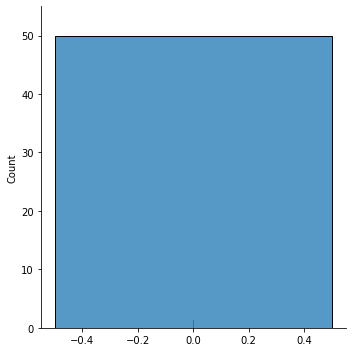

In [8]:
import seaborn as sns
sns.displot(scores,rug=True)

In [9]:
print(train_datas[:5])

[[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 11], [array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [10]:
train_datas=train_datas[:10000]
train_x=np.array([i[0] for i in train_datas])
print(type(train_x))
train_y=np.array([i[1] for i in train_datas])
print(type(train_y))

#####################
#train_x=train_x[:5000,-1,-1,-1]
#train_y=train_y[:5000,-1]
############3

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
print(train_x.shape)
train_y=train_y.reshape(-1,1)
print(train_y.shape)

(10000, 210, 160, 3)
(10000, 1)


In [12]:
history=model.fit(train_x,train_y,epochs=30,batch_size=16, validation_split=0.25)

Epoch 1/30
469/469 [==============================] - 28s 60ms/step - loss: 12.8333 - accuracy: 0.0521 - val_loss: 2.8908 - val_accuracy: 0.0544
Epoch 2/30
469/469 [==============================] - 27s 59ms/step - loss: 2.8897 - accuracy: 0.0596 - val_loss: 2.8916 - val_accuracy: 0.0544
Epoch 3/30
469/469 [==============================] - 27s 59ms/step - loss: 2.8893 - accuracy: 0.0603 - val_loss: 2.8921 - val_accuracy: 0.0544
Epoch 4/30
469/469 [==============================] - 27s 59ms/step - loss: 2.8892 - accuracy: 0.0588 - val_loss: 2.8926 - val_accuracy: 0.0544
Epoch 5/30
469/469 [==============================] - 27s 59ms/step - loss: 2.8892 - accuracy: 0.0609 - val_loss: 2.8929 - val_accuracy: 0.0544
Epoch 6/30
469/469 [==============================] - 28s 59ms/step - loss: 2.8892 - accuracy: 0.0597 - val_loss: 2.8930 - val_accuracy: 0.0544
Epoch 7/30
469/469 [==============================] - 28s 59ms/step - loss: 2.8892 - accuracy: 0.0613 - val_loss: 2.8931 - val_accuracy

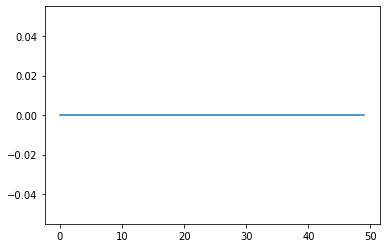

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(scores)
plt.show()

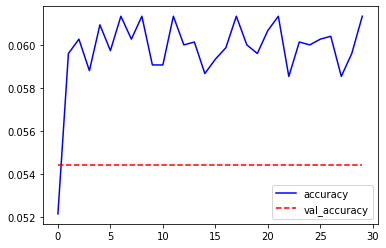

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'],'r--',label='val_accuracy')
plt.legend()
plt.show()

In [15]:
scores=[]
steps=[]
actions=[]

for i in range(5):
    obs=env.reset()
    score=0
    step=0
    for j in range(3000):
        logit=model.predict(np.expand_dims(obs,axis=0))[0]
        
        print(logit)
        action=np.argmax(logit)
        obs,reward,done,info=env.step(action)
        #env.render()
        time.sleep(0.013)
        score+=reward
        step=j
        if done :
            break
    print('epoch done')
    scores.append(score)
    steps.append(step)

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
epoch done
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.04951036]
[0.05543034 0.0573021  0.0605099  0.06142608 0.0566751  0.05584649
 0.05809416 0.0563533  0.05064983 0.05276404 0.05754822 0.05052958
 0.05482651 0.05591782 0.05347042 0.05890138 0.05424443 0.

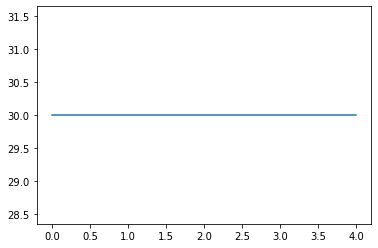

In [16]:

plt.plot(scores)
plt.show()

In [17]:
model.save('Alien-v0-test.h5')